# debug precompute

# Run Function

In [17]:
def run(gt,pr,voxelsize,name):
    eval_seg.reload()
    global mme, ev,d
    num_classes=int(gt.max()+1)
    mme=eval_seg.metrics.MME(num_classes,debug={'U':0,'B':0,'D':0,'T':0,'R':0})
    
    with Profiler(filterExternalLibraries=False):
        mme.set_reference(gt,spacing=voxelsize)
        ev,d=mme.evaluate(pr,return_debug_data=True)
    
    eval_seg.ui.plot_metric(ev,name)

    for i in d[1].gts:
        dci=d[1].gts[i]
        aa={k:dci[k] for k in ['component_pred','border_pred_with_skel','skgtn_dst_pred_out_v', 'skgtn_dst_pred_in_v']}
        skel=mme.helper['class'][1]['components'][i]['gt_skeleton']
        aa={f'com{i}(y=TP,g=FN,b=FP)':dci['component_gt']*3+dci['component_pred']*1,**aa,'skeleton':skel}
        eval_seg.ui.multi_plot_3d(aa,spacing=voxelsize)
    

## Load data

In [19]:
from ipywidgets import interact,IntSlider
import os 
import pandas as pd
from auto_profiler import Profiler
import numpy as np
root='datasets/alg_out/'
root_ct='datasets/ct'
root_out='results'
import eval_seg
eval_seg.reload()


@interact
def selectData(dataset=['Task001_LiverTumor','Task002_Pancreas','Task003_Multiorgan']):
    @interact
    # def fileviewer(file=sorted(os.listdir(f'{root}/{dataset}/GroundTruth'))):
    def fileviewer(file=sorted([f.replace('_0000.','.') for f in os.listdir(f'{root_ct}/{dataset}/')])):       
        # file='train_330.nii.gz'
        gt_orig,voxelsize_orig=eval_seg.io.read_nib(f'{root}/{dataset}/GroundTruth/{file}')
        print(voxelsize_orig)
        
        ct_orig,_=eval_seg.io.read_nib(f'{root_ct}/{dataset}/{file}'.replace('.nii.gz','_0000.nii.gz'))
        ct_orig = gt_orig if ct_orig is None else ct_orig 
    
        gtmax=(gt_orig.sum(axis=2).sum(axis=1).argmax(),gt_orig.sum(axis=2).sum(axis=0).argmax(),gt_orig.sum(axis=1).sum(axis=0).argmax())      
        # eval_seg.ui.ortho_slicer(ct_orig,{'gt':gt_orig},gtmax,spacing=voxelsize_orig)

            
        @interact
        def fileviewer2(typ=['CE','Dice','DiceCE','DiceFocal','DiceTopK10','TopK10']):
                pr_orig,pr_voxel_size = eval_seg.io.read_nib(f'{root}/{dataset}/{typ}/{file}')
                if (voxelsize_orig!=pr_voxel_size).any():
                    raise Error('voxel sizes are different')
                # global name
                name=f'{dataset}-{file}-{typ}'
                # eval_seg.ui.ortho_slicer(ct_orig,{typ:pr_orig},gtmax,spacing=voxelsize_orig)
                only_axis_data={2:'z',-1:'All',0:'x',1:'y',2:'z'}
                @interact 
                def only_axis(only_axis={only_axis_data[d]:d for d in only_axis_data}):
                    axi,ax=only_axis,only_axis_data[only_axis]
                    if axi == -1:
                        # global gt,pr,voxelsize
                        gt=gt_orig
                        pr=pr_orig
                        voxelsize=voxelsize_orig
                        print(f'dataset {dataset} ({pr.shape}) predict {typ} loaded....')
                        run(gt,pr,voxelsize,name)
                    else:                        
                        @interact
                        def onlyMaxFrame(frame=IntSlider(gtmax[axi],min=0,max=gt_orig.shape[axi]-1)):
                                # global gt,pr,voxelsize
                                eval_seg.reload()
                                gt,voxelsize=eval_seg.geometry.slice(gt_orig,voxelsize_orig,axi,[frame])
                                # print('new',voxelsize)
                                pr,_=eval_seg.geometry.slice(pr_orig,voxelsize_orig,axi,[frame])
                                ct,_=eval_seg.geometry.slice(ct_orig,voxelsize_orig,axi,[frame])
                                print(gt.shape)
                                eval_seg.ui.multi_plot_2d(
                                    ct,
                                    {'GroundTruth':gt,typ:pr},
                                    spacing=voxelsize,
                                    args={
                                        "imglabel": f"{dataset.split('_')[1]} {file.split('_')[1].split('.')[0]} {ax}={frame}",
                                        'z_titles':[frame],
                                        "add_backimg": 1,
                                        "clahe": 1,
                                        "crop2roi": 1,
                                        "zoom2segments": 1,
                                        "add_notzoom_img": 1,
                                        #                 'interactive':1,
                                        "show_tp_fp_fn": 1,
                                        "show": 1,
                                        "spacing": voxelsize,
                                    },
                                )

                                print(f'dataset {dataset} ({pr.shape}) predict {typ} loaded....')
                                
                                run(gt,pr,voxelsize,name)
                                


interactive(children=(Dropdown(description='dataset', options=('Task001_LiverTumor', 'Task002_Pancreas', 'Task…

# Details

<Object> dict_keys(['name', 'component_gt', 'component_pred', 'tpuc', 'tpu', 'pred_in_region', 'volume_gt', 'volume_pred', 'volume_tp', 'volume_fn', 'volume_fp', 'volume_tp_rate', 'volume_fn_rate', 'volume_fp_rate', 'border_gt', 'gt_skel', 'border_pred_with_skel', 'skgtn_dst_in', 'skgtn_dst_pred_in', 'skgtn_dst_pred_in_v', 'skgtn_dst_out', 'skgtn_dst_pred_out', 'skgtn_dst_pred_out_v', 'skgtn_dst_pred', 'boundary_fp', 'boundary_fn', 'boundary_tp'])


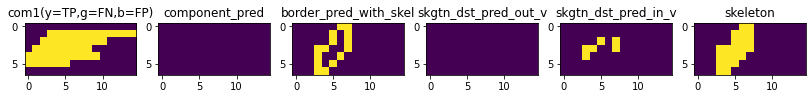

In [3]:
eval_seg.reload()
for i in d[1].gts:
    dci=d[1].gts[i]
    # aa={k:dci[k] for k in ['component_gt','rel_gt_comps','border_gt','component_pred','pred_in_region', 'border_pred']}
    # aa={k:dci[k] for k in ['component_gt','component_pred','border_pred','skgtn_dst_pred_out_v', 'skgtn_dst_pred_in_v']}
    aa={k:dci[k] for k in ['component_pred','border_pred_with_skel','skgtn_dst_pred_out_v', 'skgtn_dst_pred_in_v']}
    # aa={k:dci[k] for k in ['border_pred','skgtn_dst_out', 'skgtn_dst_in']}
    # skel2=eval_seg.geometry.skeletonize(dci['component_gt'], spacing=voxelsize)
    # skel=skel=skimage.transform.resize(skel2*1, cmi['gt'].shape,clip=0, preserve_range=True, mode='edge')>0
    skel=mme.helper['class'][1]['components'][i]['gt_skeleton']
    aa={f'com{i}(y=TP,g=FN,b=FP)':dci['component_gt']*3+dci['component_pred']*1,**aa,'skeleton':skel}
    eval_seg.ui.multi_plot_3d(aa)
    # break
print(str(dci))

In [ ]:
eval_seg.reload()
from skimage.filters import unsharp_mask, threshold_triangle, difference_of_gaussians
import scipy


for i in d[1].gts:
    dci=d[1].gts[i]
    # print(str(dci))
    newm=dci.component_gt#binary_smoothed = scipy.ndimage.median_filter(dci.component_gt, 5)
    skel=eval_seg.geometry.skeletonize(newm, spacing=voxelsize) > 0
    from skimage.morphology import skeletonize, binary_closing
    # skel2=binary_closing(skel)

    eval_seg.ui.multi_plot_3d({'gt':dci.component_gt,'newm':newm, 'skel':skel})

